In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [15]:
inspector = inspect(engine)
["measurement:"] + inspector.get_columns("measurement") + ["station:"] + inspector.get_columns("station")

['measurement:',
 {'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 'station:',
 {'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'au

In [106]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# sort date desc and grab first result
precip_results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# split text date by dashes
last_date = precip_results[0].split("-")

# turn each list item into an int
last_date = [int(x) for x in last_date]

# assemble new text date with 1 subtracted from year
start_date = f"{last_date[0] - 1:04d}-{last_date[1]:02d}-{last_date[2]:02d}"

# Perform a query to retrieve the data and precipitation scores
precip_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).all()

# put dates in a list
precip_dates = [result[0] for result in precip_results]

# put precipitation in a list.
# sometimes no precipitation is stored as None, sometimes as 0.0.
# replace None with 0.0 for easier handling
precip_inches = [0.0 if result[1] == None else result[1] for result in precip_results]

# zip the lists together
precip_zip = list(zip(precip_dates, precip_inches))

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_zip, columns = ["Date", "Precipitation"]).set_index("Date")

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date")

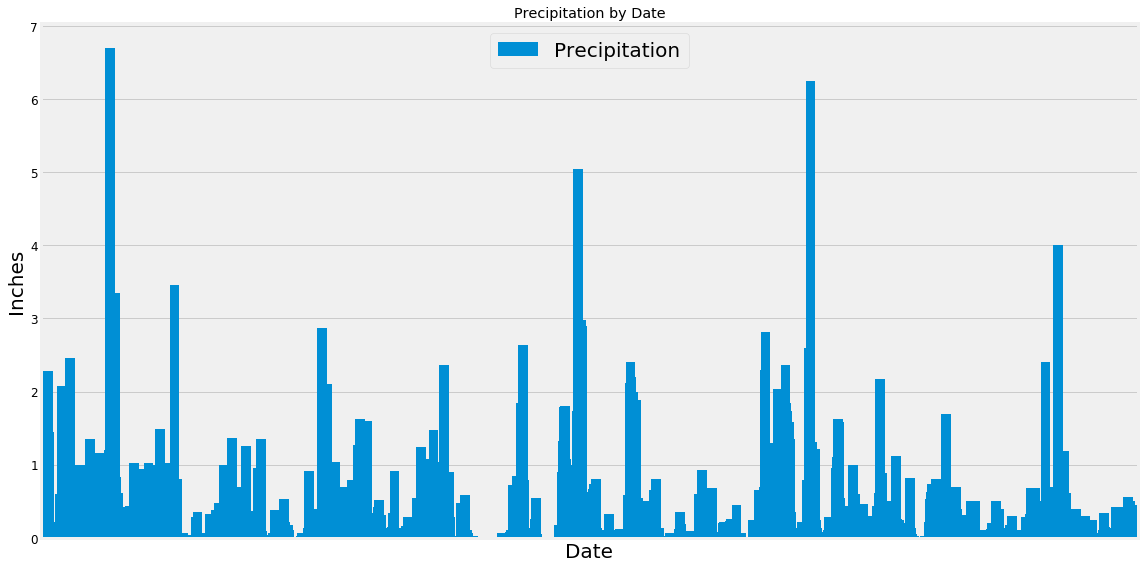

In [84]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind="bar", width=20, title="Precipitation by Date",
               figsize=(16,8), legend=True, fontsize=12, grid=True)
plt.legend(loc='upper center', fontsize='20')

# Remove xtick for every data measurement.
# there are thousands and it gets messy
plt.xticks([])

plt.xlabel("Date", fontsize=20)
plt.ylabel("Inches", fontsize=20)

plt.tight_layout()
plt.show()

In [107]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

Precipitation
count    2223.000000
mean        0.159951
std         0.441220
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000

In [114]:
# Design a query to show how many stations are available in this dataset?
station_results = session.query(func.count(Station.station)).all()
station_results

[(9)]

In [133]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# group by stations, count temperature observations per station, sort descending
station_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [132]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# most active station is first result from above
station_most_active = station_count[0][0]

# query requested stats, filtering by most active station
station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_most_active).all()
station_temps

[(54.0, 85.0, 71.66378066378067)]

In [149]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# sort date desc and grab first result
station_results = session.query(Measurement.date).filter(Measurement.station == station_most_active).\
    order_by(Measurement.date.desc()).first()

# split text date by dashes
last_date = station_results[0].split("-")

# turn each list item into an int
last_date = [int(x) for x in last_date]

# assemble new text date with 1 subtracted from year
start_date = f"{last_date[0] - 1:04d}-{last_date[1]:02d}-{last_date[2]:02d}"

station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_most_active).\
    filter(Measurement.date > start_date).all()

station_df = pd.DataFrame(station_tobs, columns=["Date", "Temperature"])

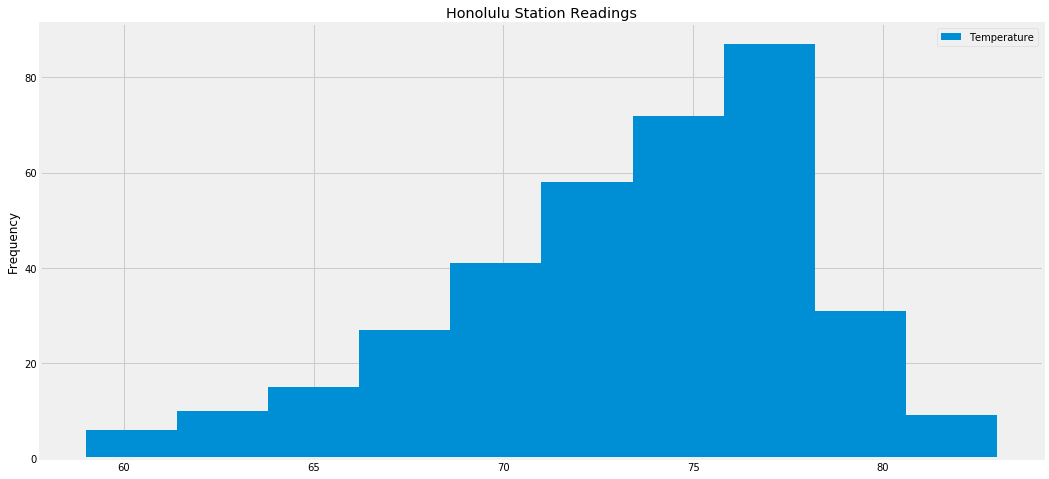

In [157]:
station_df["Temperature"].plot(kind="hist", figsize=(16, 8), title="Honolulu Station Readings", legend=True)
#plt.xlabel("Temperature")
plt.show()

In [158]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


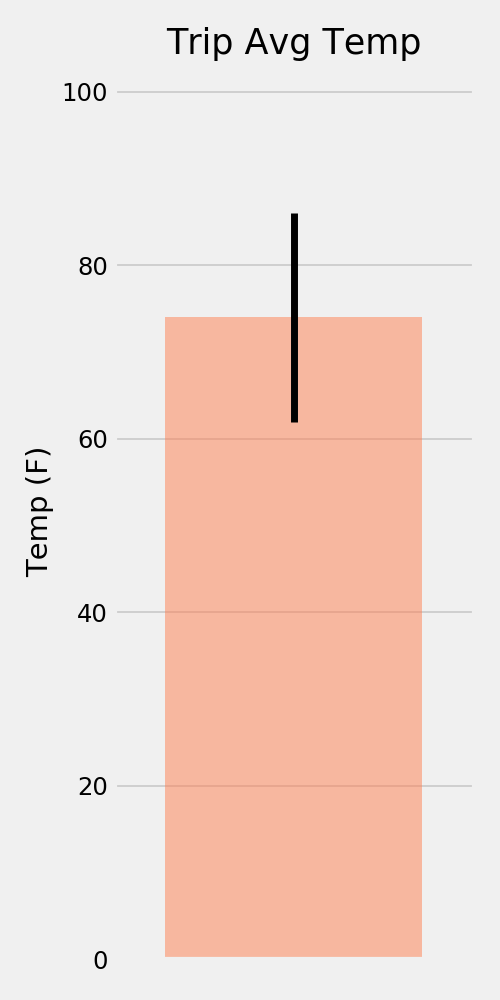

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


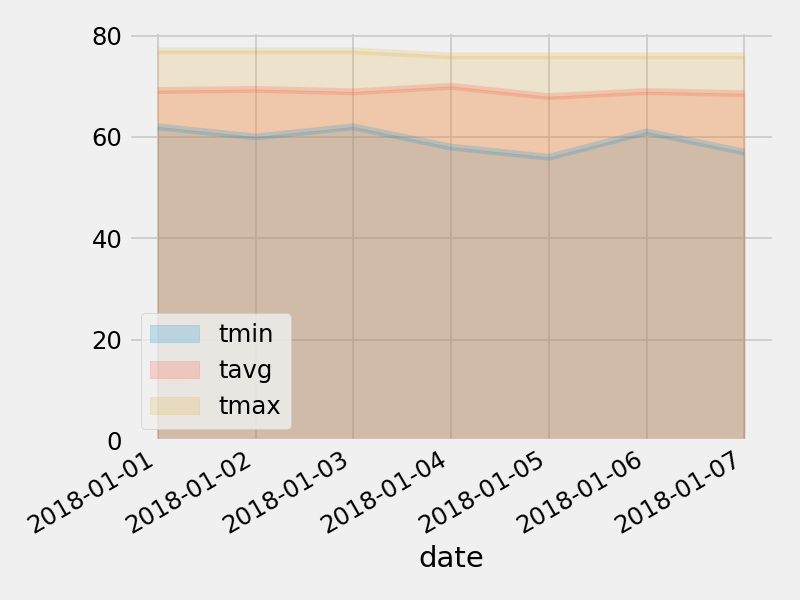

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
